In [1]:
includet("importall.jl")
includet("utils/visu.jl")
import MathOptInterface as MOI

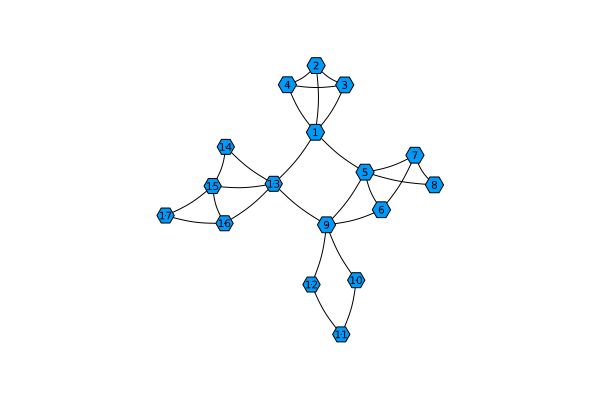

In [2]:
instance_undir = get_instance_from_folder("instances/undirected/tests/vndemo/GEANT")
visu_graph(instance_undir.v_networks[1])

In [3]:
instance = get_directed_instance(instance_undir)


InstanceVNE(Any[MetaGraph_multicycle], MetaGraph_zoo_GEANT)

In [12]:
print("Constructing compact model... ")
one_to_one = true
departure_cst = true
symmetric = true

#### Model
model = Model(CPLEX.Optimizer)
#set_optimizer_attribute(model, "CPXPARAM_MIP_Strategy_VariableSelect", 0)
set_optimizer_attribute(model, "CPXPARAM_MIP_Display", 2)
#set_optimizer_attribute(model, "CPXPARAM_MIP_Interval", 50)

# CUTS
set_optimizer_attribute(model, "CPXPARAM_MIP_Cuts_Nodecuts", 0)
#set_optimizer_attribute(model, "CPXPARAM_MIP_Cuts_ZeroHalfCut", -1)
#set_optimizer_attribute(model, "CPXPARAM_MIP_Cuts_LiftProj", -1)
#set_optimizer_attribute(model, "CPXPARAM_MIP_Cuts_Gomory", -1)
#set_optimizer_attribute(model, "CPXPARAM_MIP_Cuts_GUBCovers", 2)

### Variables
x_variables = @variable(model, x[v_network in instance.v_networks, vertices(v_network), vertices(instance.s_network)], binary=true);
y_variables = @variable(model, y[v_network in instance.v_networks, edges(v_network), edges(instance.s_network)], binary=true);
#x_variables = @variable(model, 0 <=  x[v_network in instance.v_networks, vertices(v_network), vertices(instance.s_network)] <= 1);
#y_variables = @variable(model, 0 <= y[v_network in instance.v_networks, edges(v_network), edges(instance.s_network)] <= 1);

### Objective
placement_cost = @expression(model, sum( instance.s_network[s_node][:cost] * v_network[v_node][:dem] * x[v_network, v_node, s_node] 
    for v_network in instance.v_networks for v_node in vertices(v_network) for s_node in vertices(instance.s_network) ))
routing_cost = @expression(model, sum( instance.s_network[src(s_edge), dst(s_edge)][:cost] * v_network[src(v_edge), dst(v_edge)][:dem] * y[v_network, v_edge, s_edge]
    for v_network in instance.v_networks for v_edge in edges(v_network) for s_edge in edges(instance.s_network) ))
@objective(model, Min, placement_cost + routing_cost);


### Constraints

## Nodes

# one substrate node per virtual node
for v_network in instance.v_networks
    for v_node in vertices(v_network)
        @constraint(model, sum(x[v_network, v_node, s_node] for s_node in vertices(instance.s_network)) == 1)
    end
end

# if one to one : one virtual node per substrate node
if one_to_one
    for s_node in vertices(instance.s_network)
        for v_network in instance.v_networks
            @constraint(model, sum(x[v_network, v_node, s_node] for v_node in vertices(v_network)) <= 1)
        end
    end
end



# node capacity
for s_node in vertices(instance.s_network)
    @constraint(model, 
        sum( v_network[v_node][:dem] * x[v_network, v_node, s_node] 
            for v_network in instance.v_networks for v_node in vertices(v_network) ) 
        <= 
        instance.s_network[s_node][:cap] )
end


## Edges 

# edge capacity
for s_edge in edges(instance.s_network)
    @constraint(model, 
        sum( v_network[src(v_edge), dst(v_edge)][:dem] * y[v_network, v_edge, s_edge] 
            for v_network in instance.v_networks for v_edge in edges(v_network)) 
        <= 
        instance.s_network[src(s_edge), dst(s_edge)][:cap] )
end

# Flow conservation
for s_node in vertices(instance.s_network)
    for v_network in instance.v_networks
        for v_edge in edges(v_network)
            @constraint(model, 
                x[v_network, src(v_edge), s_node] - x[v_network, dst(v_edge), s_node] 
                <=
                sum(y[v_network, v_edge, s_edge] for s_edge in get_out_edges(instance.s_network, s_node)) - 
                    sum(y[v_network, v_edge, s_edge] for s_edge in get_in_edges(instance.s_network, s_node))
            )
        end
    end
end

## Additional constraints : Node + Edge
if one_to_one
    if departure_cst
        for s_node in vertices(instance.s_network)
            for v_network in instance.v_networks
                for v_node in vertices(v_network)
                    for v_edge in get_out_edges(v_network, v_node)
                        @constraint(model, sum(y[v_network, v_edge, s_edge] for s_edge in get_out_edges(instance.s_network, s_node)) >= x[v_network, v_node, s_node])
                    end
                    for v_edge in get_in_edges(v_network, v_node)
                        @constraint(model, sum(y[v_network, v_edge, s_edge] for s_edge in get_in_edges(instance.s_network, s_node)) >= x[v_network, v_node, s_node])
                    end
                end
            end
        end
    end
end

## Symmetric edges (mostly for undirected)
if symmetric
    for v_network in instance.v_networks
        for v_edge in edges(v_network)
            for s_edge in edges(instance.s_network)
                @constraint(model, y[v_network, v_edge, s_edge] == y[v_network, get_edge(v_network, dst(v_edge), src(v_edge)), 
                                            get_edge(instance.s_network, dst(s_edge), src(s_edge))])
            end
        end
    end
end

println("done.")


Constructing compact model... done.



Root node processing (before b&c):
  Real time             =    0.00 sec. (0.08 ticks)
Sequential b&c:
  Real time             =    0.00 sec. (0.00 ticks)
                          ------------
Total (root+branch&cut) =    0.00 sec. (0.08 ticks)


In [13]:
function my_callback_function(cb_data)
    #x_val = callback_value(cb_data, x)
    println("On est là ou quoi")
end

my_callback_function (generic function with 1 method)

In [14]:
set_attribute(model, MOI.UserCutCallback(), my_callback_function)

In [15]:
optimize!(model)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Threads                                 1
Generic callback                                 0x40
Tried aggregator 2 times.
MIP Presolve eliminated 6635 rows and 0 columns.
Aggregator did 3294 substitutions.
Reduced MIP has 3358 rows, 3974 columns, and 22150 nonzeros.
Reduced MIP has 3974 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.04 sec. (39.70 ticks)
Probing time = 0.00 sec. (3.94 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 3358 rows, 3974 columns, and 22150 nonzeros.
Reduced MIP has 3974 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (12.54 ticks)
Probing time = 0.00 sec. (3.91 ticks)
Clique table members: 2329.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.27 sec. (419.19 ticks)

        Nodes                                         Cuts

On est là ou quoi


*     0+    0                           38.0000       27.0000            28.95%
Detecting symmetries...
      0     2       27.0000   497       38.0000       27.0000     3251   28.95%
Elapsed time = 3.34 sec. (5075.42 ticks, tree = 0.01 MB, solutions = 1)
On est là ou quoi
On est là ou quoi


      1     3       29.1602   361       38.0000       27.0000     6513   28.95%
On est là ou quoi
On est là ou quoi
      2     4       27.0000   726       38.0000       27.0000     8026   28.95%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


      4     6       30.1273   340       38.0000       27.0000    11339   28.95%
On est là ou quoi
On est là ou quoi


      5     7       27.0000  1052       38.0000       27.0000    13366   28.95%
On est là ou quoi
On est là ou quoi


      6     8       27.0000  1151       38.0000       27.0000    14731   28.95%
On est là ou quoi
On est là ou quoi


      7     9       28.0000   317       38.0000       27.0000    17292   28.95%
On est là ou quoi
On est là ou quoi
      8    10       27.0000   945       38.0000       27.0000    18200   28.95%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
     10    12       30.0000   348       38.0000       27.0000    20862   28.95%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
     12    14       28.9947   360       38.0000       27.0000    25078   28.95%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
     17    19       27.0000   981       38.0000       27.0000    31501   28.95%
Elapsed time = 6.61 sec. (10100.29 ticks, tree = 0.11 MB, solutions = 1)
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


     23    25       27.0000   961       38.0000       27.0000    36402   28.95%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


     28    30       27.0000  1071       38.0000       27.0000    42242   28.95%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


     33    35       28.9767   293       38.0000       27.0000    53431   28.95%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
     39    41       27.0000   870       38.0000       27.0000    57684   28.95%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
     50    52       27.0000   509       38.0000       27.0000    61669   28.95%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


     58    60       27.0028   548       38.0000       27.0000    68108   28.95%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
     65    67       30.0325   340       38.0000       27.0000    72606   28.95%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
*    70+   70                           37.0000       27.0000            27.03%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


*    80+   72                           36.0000       27.0000            25.00%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
     94    79       30.0000   221       36.0000       27.0000    79221   25.00%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
    110    95       32.1172   295       36.0000       27.0000    84240   25.00%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


    133   115       29.8936   312       36.0000       27.0000    90079   25.00%
Elapsed time = 13.93 sec. (20465.11 ticks, tree = 1.15 MB, solutions = 3)
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
    154   132       29.0000   346       36.0000       27.0000    96238   25.00%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
    183   157       28.7543   325       36.0000       27.0000   102713   25.00%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


*   210   155      integral     0       34.0000       27.0000   107774   20.59%
On est là ou quoi
On est là ou quoi
    211   155       28.0000   157       34.0000       27.0000   109355   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
    239   179       30.0000   333       34.0000       27.0000   116274   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
    259   195       27.7051   454       34.0000       27.0000   123858   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


    280   216       29.3140   339       34.0000       27.0000   129161   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
    314   246       30.0250   339       34.0000       27.0000   135248   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
    328   256       28.1667   267       34.0000       27.0000   141156   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
    362   286       28.3286   323       34.0000       27.0000   148517   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
    388   308       30.0000   410       34.0000       27.0000   154652   20.59%
Elapsed time = 21.98 sec. (31227.95 ticks, tree = 1.29 MB, solutions = 4)
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


    408   324       32.5000   295       34.0000       27.0000   161146   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
    425   335       32.0000   236       34.0000       27.0000   167505   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
    452   358       30.0556   299       34.0000       27.0000   173508   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


    469   371       31.5839   358       34.0000       27.0000   179649   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
    489   385       30.9200   300       34.0000       27.0000   184385   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


    503   399       27.0000   308       34.0000       27.0000   189853   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


    505   401       27.0000   322       34.0000       27.0000   191363   20.59%

Performing restart 1

Repeating presolve.
Tried aggregator 1 time.
Reduced MIP has 3358 rows, 3974 columns, and 22150 nonzeros.
Reduced MIP has 3974 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (9.61 ticks)
Tried aggregator 1 time.
Reduced MIP has 3358 rows, 3974 columns, and 22150 nonzeros.
Reduced MIP has 3974 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (13.08 ticks)
Represolve time = 0.04 sec. (39.75 ticks)
On est là ou quoi


On est là ou quoi


    506     2       27.0000   497       34.0000       27.0000   194614   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


    508     4       27.0000   564       34.0000       27.0000   198589   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


    512     8       30.0111   259       34.0000       27.0000   203097   20.59%
Elapsed time = 33.09 sec. (46355.48 ticks, tree = 0.07 MB, solutions = 4)
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


    520    14       32.8333   185       34.0000       27.0000   206747   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


    528    20       31.4667   151       34.0000       27.0000   209487   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


    540    25       29.1615   332       34.0000       27.0000   213126   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
    550    33       31.1362   244       34.0000       27.0000   215709   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


    558    38       32.7300   218       34.0000       27.0000   218926   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


    568    42       27.0000  1142       34.0000       27.0000   220725   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


    571    45       27.0000  1232       34.0000       27.0000   220825   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


    576    50       27.0000  1169       34.0000       27.0000   221144   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


    586    60       27.0000  1145       34.0000       27.0000   221415   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


    606    80       27.0000   911       34.0000       27.0000   222212   20.59%
Elapsed time = 44.67 sec. (62488.59 ticks, tree = 1.53 MB, solutions = 4)
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


    619    93       29.5051   431       34.0000       27.0000   225156   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
    646   120       31.0856   248       34.0000       27.0000   226836   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


    673   142       27.0867   424       34.0000       27.0000   230739   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


    693   162       29.4000   194       34.0000       27.0000   232881   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


    726   191       28.4953   394       34.0000       27.0000   236470   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


    762   227       29.1337   606       34.0000       27.0000   240396   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
    821   282       31.0674   402       34.0000       27.0000   244963   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


    928   377        cutoff             34.0000       27.0000   249219   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


    938   384       32.9310   244       34.0000       27.0000   254668   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
    945   389       28.1353   590       34.0000       27.0000   259335   20.59%
Elapsed time = 52.51 sec. (72699.25 ticks, tree = 3.69 MB, solutions = 4)
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
    990   432       30.5667   411       34.0000       27.0000   263885   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   1048   482       27.7744   411       34.0000       27.0000   269464   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   1071   505       27.9068   421       34.0000       27.0000   272581   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   1100   530       28.1411   656       34.0000       27.0000   279320   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   1115   545       28.3495   547       34.0000       27.0000   283057   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


   1161   589        cutoff             34.0000       27.0000   288181   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


   1226   648       30.8973   396       34.0000       27.0000   293024   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   1316   734       28.7024   346       34.0000       27.0000   298540   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


   1346   764       29.5301   497       34.0000       27.0000   302997   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   1407   819       29.5120   326       34.0000       27.0000   308714   20.59%
Elapsed time = 60.49 sec. (82939.79 ticks, tree = 7.19 MB, solutions = 4)
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


   1422   832        cutoff             34.0000       27.0000   315154   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


   1439   845       29.0191   419       34.0000       27.0000   320896   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   1474   876        cutoff             34.0000       27.0000   325742   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


   1506   902       30.8790   319       34.0000       27.0000   331538   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   1602   952       28.5706   344       34.0000       27.0000   338316   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


   1606   956       29.1538   347       34.0000       27.0000   339431   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   1703  1044       27.0000   563       34.0000       27.0000   344042   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   1727  1068       27.0000   492       34.0000       27.0000   347196   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   1754  1095       27.1391   567       34.0000       27.0000   352824   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   1803  1142       32.8261   288       34.0000       27.0000   358737   20.59%
Elapsed time = 69.62 sec. (95280.55 ticks, tree = 16.04 MB, solutions = 4)
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   1858  1193       30.8893   435       34.0000       27.0000   364589   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   1991  1318       32.5330   330       34.0000       27.0000   368845   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   2059  1378       29.0743   468       34.0000       27.0000   374594   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   2124  1443       31.9303   510       34.0000       27.0000   379922   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


   2162  1477       30.9356   369       34.0000       27.0000   385473   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   2184  1499       28.5000   386       34.0000       27.0000   391318   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


   2208  1521       28.7604   380       34.0000       27.0000   397516   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   2230  1543       30.2889   469       34.0000       27.0000   404427   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   2255  1566       30.9272   429       34.0000       27.0000   409282   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   2276  1587       32.4144   435       34.0000       27.0000   413991   20.59%
Elapsed time = 77.82 sec. (105126.99 ticks, tree = 28.27 MB, solutions = 4)
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   2305  1609       28.1429   309       34.0000       27.0000   418998   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   2327  1631       28.7011   487       34.0000       27.0000   423646   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


   2395  1699       29.0833   372       34.0000       27.0000   427237   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   2495  1799       32.3236   528       34.0000       27.0000   431834   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   2549  1848       30.4722   334       34.0000       27.0000   436461   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   2581  1874       30.1626   443       34.0000       27.0000   441547   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   2594  1883       28.6804   618       34.0000       27.0000   446053   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


   2648  1937       29.8241   545       34.0000       27.0000   450367   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


   2699  1985       32.1250   442       34.0000       27.0000   454915   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   2805  2073       29.4270   393       34.0000       27.0000   474043   20.59%
Elapsed time = 88.84 sec. (117908.13 ticks, tree = 41.77 MB, solutions = 4)
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   2955  2199       30.7289   340       34.0000       27.0000   494391   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   3092  2322       30.5827   373       34.0000       27.0000   511478   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   3113  2339       28.4664   421       34.0000       27.0000   516787   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   3325  2537       29.6573   400       34.0000       27.0000   536569   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   3424  2623       31.6354   200       34.0000       27.0000   556457   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   3562  2743       30.7688   346       34.0000       27.0000   575698   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   3677  2838       31.4887   337       34.0000       27.0000   595503   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   3840  2986       30.5243   359       34.0000       27.0000   615611   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


   4004  3124       30.6842   396       34.0000       27.0000   635757   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


   4159  3264       28.2274   544       34.0000       27.0000   655129   20.59%
Elapsed time = 118.09 sec. (156819.55 ticks, tree = 74.51 MB, solutions = 4)
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   4255  3336       29.0480   437       34.0000       27.0000   674119   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


   4406  3470       32.2941   279       34.0000       27.0000   692888   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   4542  3597       31.6087   264       34.0000       27.0000   710879   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   4639  3680       29.7927   353       34.0000       27.0000   729986   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   4748  3782       27.5896   571       34.0000       27.0000   748804   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


   4806  3840       30.2674   495       34.0000       27.0000   758512   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   4933  3963       29.9903   363       34.0000       27.0000   775685   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   5060  4066       32.4574   399       34.0000       27.0000   794102   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


   5193  4189       27.2895   435       34.0000       27.0000   815081   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   5297  4283       28.4207   304       34.0000       27.0000   833434   20.59%
Elapsed time = 152.57 sec. (198419.30 ticks, tree = 95.77 MB, solutions = 4)
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   5469  4447       28.1837   438       34.0000       27.0000   851640   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   5580  4554       31.1716   291       34.0000       27.0000   869289   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   5684  4646       30.2496   427       34.0000       27.0000   887175   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
   5787  4737       29.6254   372       34.0000       27.0000   906589   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


   5933  4870       31.9717   366       34.0000       27.0000   926061   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


   6006  4931       29.7473   337       34.0000       27.0000   939942   20.59%
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
   6164  5079       29.2104   355       34.0000       27.0000   958442   20.59%
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi


On est là ou quoi
On est là ou quoi
On est là ou quoi
On est là ou quoi
